Philippe Joly
2024-07-14

# Football line number detection
This is an other attempt at the detection of football lines. Instead of traditional computer vision methods (like the ones used in the first and second notebook), this notebook explores the performance of a machine learning model (yoloV8)

In [ ]:
!pip install roboflow
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 76.2/76.2 kB 1.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 178.7/178.7 kB 3.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 54.5/54.5 kB 3.9 MB/s eta 0:00:00
  Attempting uninstall: chardet
    Found existing installation: chardet 5.2.0
    Uninstalling chardet-5.2.0:
      Successfully uninstalled chardet-5.2.0
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 801.6/801.6 kB 9.6 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
 

In [ ]:
from roboflow import Roboflow
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import os
from ultralytics import YOLO
from PIL import Image, ImageDraw
import random
import shutil
from google.colab import files, userdata
import subprocess

## Importing Data

In [ ]:
rf = Roboflow(api_key=userdata.get('roboflow_key'))

project = rf.workspace("fh-technikum-wien-m15r2").project("computer-vision-additional-dataset")
version = project.version(1)
dataset = version.download("yolov8")
# https://universe.roboflow.com/fh-technikum-wien-m15r2/computer-vision-additional-dataset

# other option: https://universe.roboflow.com/sigil-analytics/yard_new_marks

loading Roboflow workspace...
loading Roboflow project...
Dependency ultralytics==8.0.196 is required but found version=8.2.57, to fix: `pip install ultralytics==8.0.196`



Extracting Dataset Version Zip to signs-3 in yolov8:: 100%|██████████| 38081/38081 [00:08<00:00, 4289.16it/s]


In [ ]:
def show_lbl(img_path, lbl_path):
  img = Image.open(img_path)

  with open(lbl_path, 'r') as f:
    labels = f.readlines()

  draw = ImageDraw.Draw(img)
  for label in labels:
    class_id, x_center, y_center, width, height = map(float, label.strip().split())
    left = (x_center - width/2) * img.width
    top = (y_center - height/2) * img.height
    right = (x_center + width/2) * img.width
    bottom = (y_center + height/2) * img.height
    draw.rectangle([left, top, right, bottom], outline="red", width=2)
    draw.text((left, bottom+20), str(class_id), fill="red")

  plt.figure(figsize=(10, 10))
  plt.imshow(img)
  plt.axis('off')
  plt.show()

## Treating dataset

In [ ]:
imgs_train = [f for f in os.listdir(os.path.join(dataset.location, "train", "images")) if f.endswith(('.jpg', '.png', '.jpeg'))]
imgs_val = [f for f in os.listdir(os.path.join(dataset.location, "valid", "images")) if f.endswith(('.jpg', '.png', '.jpeg'))]
lbls_train = [f for f in os.listdir(os.path.join(dataset.location, "train", "labels")) if f.endswith('.txt')]
lbls_val = [f for f in os.listdir(os.path.join(dataset.location, "valid", "labels")) if f.endswith('.txt')]

In [ ]:
lbls = {
}

In [ ]:
train_labels_path = os.path.join(dataset.location, "train", "labels", "*.txt")
valid_labels_path = os.path.join(dataset.location, "valid", "labels", "*.txt")

subprocess.run(f"sed -i 's/^2/1/' {train_labels_path}", shell=True)
subprocess.run(f"sed -i 's/^2/1/' {valid_labels_path}", shell=True)

CompletedProcess(args="sed -i 's/^2/1/' /content/signs-3/valid/labels/*.txt", returncode=0)

In [ ]:
for i in imgs_train:
  name = os.path.join(dataset.location, "train", "images", i)
  img  = Image.open(name)
  img = img.convert('L')
  img.save(name)

for i in imgs_val:
  name = os.path.join(dataset.location, "valid", "images", i)
  img  = Image.open(name)
  img = img.convert('L')
  img.save(name)

In [ ]:
shutil.move("signs-3/data.yaml", "data.yaml")
shutil.move("signs-3/train", "datasets/signs-3/train")
shutil.move("signs-3/valid", "datasets/signs-3/valid")

dataset_1.location = "datasets/signs-3"

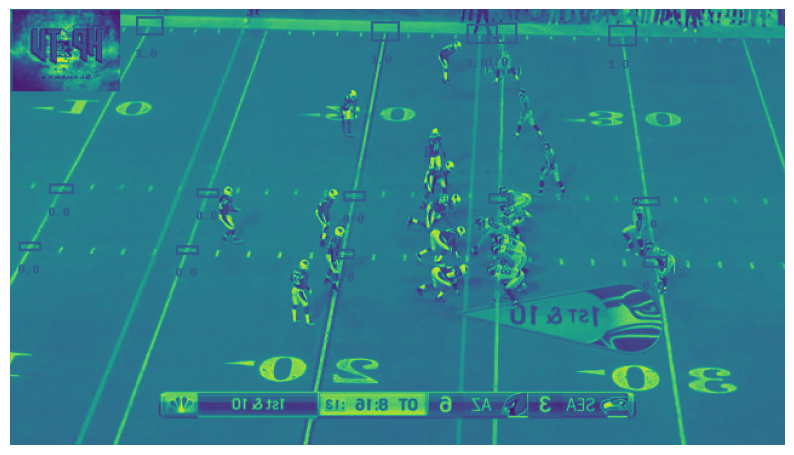

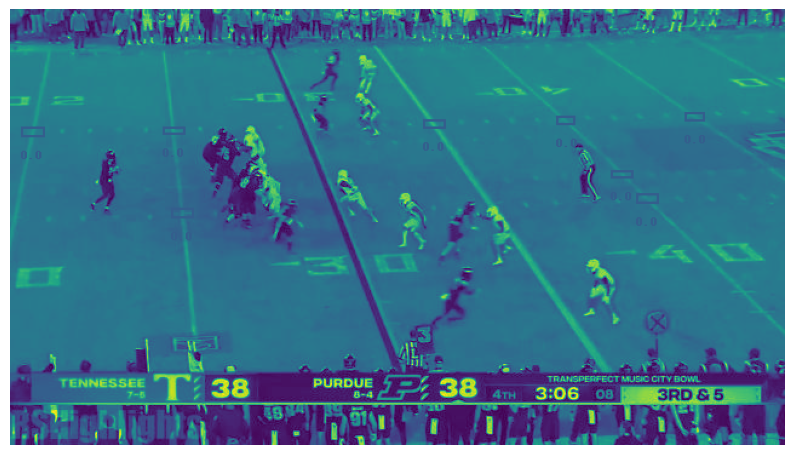

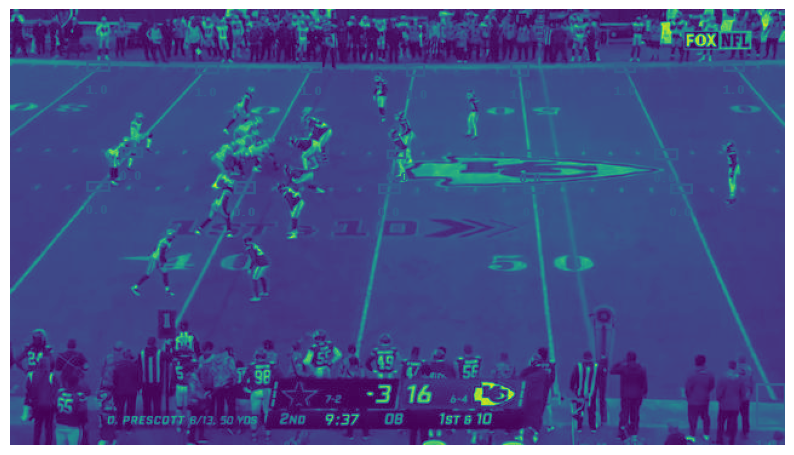

In [ ]:
for i in range(3):
  i = random.randrange(0, 1000)
  img = os.path.join(dataset.location, "train", "images", imgs_train[i])
  lbl = os.path.join(dataset.location, "train", "labels",os.path.splitext(imgs_train[i])[0]+".txt")
  show_lbl(img, lbl)

## Training

In [ ]:
!yolo task = detect mode = train model = yolov8x.pt data = "data.yaml" epochs = 4 imgsz = 640 batch = 8

Ultralytics YOLOv8.2.57 🚀 Python-3.10.12 torch-2.3.0+cu121 CUDA:0 (Tesla T4, 15102MiB)
engine/trainer: task=detect, mode=train, model=yolov8x.pt, data=data.yaml, epochs=4, time=None, patience=100, batch=8, imgsz=640, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frames=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, show_boxes=True, line_w

## Save models

In [ ]:
files.download("runs/segment/train/weights/best.pt")

In [ ]:
files.download("runs/segment/train/weights/last.pt")